In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.colors as mcolors
from matplotlib import cm
import math
from matplotlib.lines import Line2D

In [2]:
path_gps='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/moransi_healthy/sfintegrated/'
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_rna='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/'
path_data=path_rna+'combined/'
path_query=path_rna+'GSE137909/GEO/'
path_model=path_query+'run_scArches1603792372.695119/'

In [3]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'
sc._settings.ScanpyConfig.figdir=Path(path_fig)

#### Load data

In [4]:
# Reload GPs
genes_hc_data = pd.read_table(path_gps+'gene_hc_t3.tsv',index_col=0)

In [5]:
# Load atlas beta cells
adata_rn_b=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')
adata_rn_b.shape

(102143, 30672)

In [6]:
# Load external query adata and latent
adata_q=sc.AnnData(X=sc.read(path_model+'latent_query.h5ad').X,
                   obs=sc.read(path_query+'adata.h5ad',backed='r').obs)

In [7]:
# Load query expression
adata_q_expr=sc.read(path_query+'adata.h5ad')

In [8]:
# Load original publication query obs for their subtype annotation
obs_q_feng=pd.read_excel(path_rna+'GSE137909/GEO/1-s2.0-S2212877820300569-mmc1.xlsx',
                         skiprows=1,index_col=0)

#### Umap and cell subset for plotting

The analysis will be performed on health yadult cells shown on atlas beta cells thus subset to query adult controls and atlas beta cells for umap

In [9]:
# Joint integrated embed of query adult control and atlas
adata_embed=sc.concat([adata_q[(adata_q.obs.cell_type=='beta').values &
                              adata_q.obs.donor.str.contains('Control').values,:],
                       sc.AnnData(X=adata_rn_b.obsm['X_integrated'],obs=adata_rn_b.obs)],
                      index_unique='-',keys=['query','ref'],join='outer',label='ref_query')

In [63]:
# Shared UMAP embed of atlas and control query
sc.pp.neighbors(adata_embed, n_neighbors=15,)
sc.tl.umap(adata_embed,min_dist=0, spread=1, )

In [65]:
# Save UMAP embed
if False:
    pd.DataFrame(adata_embed.obsm['X_umap'],index=adata_embed.obs_names).to_csv(
        path_model+'umap_beta_atlas_queryControl.tsv',sep='\t')

In [10]:
# Reload UMAP
if False:
    adata_embed.obsm['X_umap']=pd.read_table(
        path_model+'umap_beta_atlas_queryControl.tsv',index_col=0
    ).loc[adata_embed.obs_names,:].values

In [11]:
# Filter for plotting low Q cells
cells_plot=list(set(adata_embed.obs_names)-set([
    c+'-ref' for c in adata_rn_b[
    adata_rn_b.obs['leiden_r1.5_parsed_const'].str.contains('low_quality'),:].obs_names]))
nolowq_sub= ~adata_rn_b.obs['leiden_r1.5_parsed_const'].str.contains('low_quality')

#### Compute GP scores accross samples

In [11]:
# Healthy adult samples
# Already ordered for plotting
samples=['Fltp_adult_mouse1_head_Fltp-','Fltp_adult_mouse3_tail_Fltp-',
         'Fltp_adult_mouse2_head_Fltp+', 'Fltp_adult_mouse4_tail_Fltp+',
         'STZ_G1_control','VSG_MUC13633_chow_WT','VSG_MUC13634_chow_WT',]
samples_q=adata_q[adata_q.obs.donor.str.contains('Control'),:].obs.donor.unique()

In [12]:
# Atlas: gene cluster scores on healthy beta cells computed per sample
for sample in samples:
    adata_temp=adata_rn_b[adata_rn_b.obs.study_sample_design==sample,:].copy()
    for hc,hc_data in genes_hc_data.groupby('hc'):
        #print(sample, hc)
        hc_genes=list(hc_data.index)
        score_name='gene_score_cluster_hc'+str(hc)
        sc.tl.score_genes(adata_temp, 
                          gene_list=hc_genes, 
                         score_name=score_name, use_raw=False)
        adata_rn_b.obs.loc[adata_temp.obs_names,score_name]=adata_temp.obs[score_name]
del adata_temp

In [13]:
# N beta cells per query donor
display(adata_q[(adata_q.obs.cell_type=='beta').values &
                              adata_q.obs.donor.str.contains('Control').values,:
       ].obs['donor'].value_counts())
print('N all cells:',adata_q[(adata_q.obs.cell_type=='beta').values &
                              adata_q.obs.donor.str.contains('Control').values,:
       ].shape[0])

Ngn3Cre_Control_1    210
Ngn3Cre_Control_2    138
Ngn3Cre_Control_3     21
Name: donor, dtype: int64

N all cells: 369


Due to low number of querty cells they wont be separated by sample for top cell scoring

In [14]:
# Query: gene cluster scores on healthy beta cells computed for whole dataset as 
# low number of cells per sample
adata_temp=adata_q_expr[(adata_q_expr.obs.cell_type=='beta').values &
                              adata_q_expr.obs.donor.str.contains('Control').values,:
       ].copy()
for hc,hc_data in genes_hc_data.groupby('hc'):
    hc_genes=list(hc_data.index)
    score_name='gene_score_cluster_hc'+str(hc)
    sc.tl.score_genes(adata_temp, 
                      gene_list=hc_genes, 
                     score_name=score_name, use_raw=False)
    adata_q_expr.obs.loc[adata_temp.obs_names,score_name]=adata_temp.obs[score_name]
del adata_temp

#### Plot top N cells on UMAP

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'pre_cell_type' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused catego

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'hc_top' as categorical
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/a

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'hc_gene_programs_parsed' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'leiden_r1.5_parsed' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/l

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'leiden_r0.8' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'leiden_r0.3' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-p

... storing 'leiden_r1.5' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'leiden_r2' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'leiden_r20' as categorical
/home/icb/karin.hrovatin/minic

... storing 'cell_subtype_multiplet' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_integrated' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'leiden_r0.4' as categorical
/home/i

... storing 'cell_type' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_multiplet' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'cell_subtype' as categorical
/home/icb/karin.hrov

... storing 'hc_top' as categorical
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future

... storing 'leiden_r1.5_parsed' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'leiden_r1.5_parsed_const' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'hc_top' as categorical
Observation 

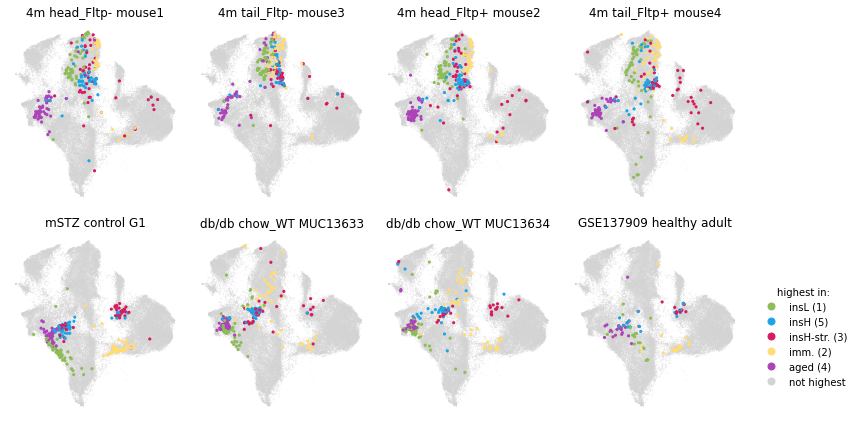

In [170]:
# Plot top N cells per GP and sample
# Plot all atlas (and used query) cells as background, excluding atlas lowQ cells
cl_names_map={'1':'insL (1)','2':'imm. (2)', '3':'insH-str. (3)','4':'aged (4)','5':'insH (5)'}
cmap={'insL (1)':'#8DBD57','insH (5)':'#1EA5E5','insH-str. (3)':'#D81B60',
      'imm. (2)':'#FFDC74', 'aged (4)':'#AE43B9', 'not highest':'lightgray'}
n_samples=len(samples)+1 # For the query
ncol=math.ceil(n_samples/2)
fig,axs=plt.subplots(2,ncol,figsize=(ncol*3,3*2))
# Atlas healthy adult sample plots
for i,sample in enumerate(samples):
    ax=axs[i//ncol,i%ncol]
    # Background
    sc.pl.umap(adata_embed[cells_plot,:],ax=ax,show=False, frameon=False)
    adata_temp=adata_rn_b[
        nolowq_sub,:][adata_rn_b[nolowq_sub,:].obs.study_sample_design==sample,:].copy()
    # Make new adata so that cells can be scored hig hfor 2 gene groups and then one of 
    # them will be on top based on random ordering
    adatas_temp=[]
    for hc in genes_hc_data.hc.unique():
        # Get top N cells per gene group
        top_cells=adata_temp.obs.sort_values(
            'gene_score_cluster_hc'+str(hc),ascending=False).head(50).index
        adata_temp_sub=adata_temp[top_cells,:].copy()
        adata_temp_sub.obs['hc_top']=cl_names_map[str(hc)]
        adatas_temp.append(adata_temp_sub)
    adata_temp=sc.concat(adatas_temp)
    adata_temp.obsm['X_umap']=adata_embed[
        [c+'-ref' for c in adata_temp.obs_names],:].obsm['X_umap']
    # Reset index as some cells may be repeated
    adata_temp.obs_names=[str(c) for c in range(adata_temp.shape[0])]
    np.random.seed(0)
    random_indices=np.random.permutation(adata_temp.obs_names)
    sc.pl.umap(adata_temp[random_indices,:],color='hc_top',show=False,ax=ax,
                    s=40, palette=cmap, frameon=False)
    ax.set_title(' '.join([adata_temp.obs['study_parsed'][0],
                          adata_temp.obs['design'][0],adata_temp.obs['file'][0]]))
    ax.get_legend().remove()
# Query - see above comments for atlas
ax=axs[2-1,ncol-1]
sc.pl.umap(adata_embed[cells_plot,:],ax=ax,show=False, frameon=False)
adata_temp=adata_q_expr[(adata_q_expr.obs.cell_type=='beta').values &
                              adata_q_expr.obs.donor.str.contains('Control').values,:].copy()
adatas_temp=[]
for hc in genes_hc_data.hc.unique():
    top_cells=adata_temp.obs.sort_values(
        'gene_score_cluster_hc'+str(hc),ascending=False).head(20).index
    adata_temp_sub=adata_temp[top_cells,:].copy()
    adata_temp_sub.obs['hc_top']=cl_names_map[str(hc)]
    adatas_temp.append(adata_temp_sub)
adata_temp=sc.concat(adatas_temp)
adata_temp.obsm['X_umap']=adata_embed[
    [c+'-query' for c in adata_temp.obs_names],:].obsm['X_umap']
adata_temp.obs_names=[str(c) for c in range(adata_temp.shape[0])]
np.random.seed(0)
random_indices=np.random.permutation(adata_temp.obs_names)
sc.pl.umap(adata_temp[random_indices,:],color='hc_top',show=False,ax=ax,
                s=40, palette=cmap, frameon=False)
ax.set_title('GSE137909 healthy adult')

# Add background to legend
l1=ax.legend(handles=[
    Line2D([0], [0], marker='o', color=c,lw=0, label=l,
    markerfacecolor=c, markersize=7) for l,c in cmap.items()], frameon=False)
             
l1.set_title("highest in:") 
l1.set_bbox_to_anchor((1.05,0.75))
    
fig.tight_layout()
plt.savefig(path_fig+'umap_beta_healthyvar_top_atlasQueru_eopt.png',dpi=300,bbox_inches='tight')

del adata_temp
del adatas_temp

#### Feng et al annotation of virgin beta cells

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'strain' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categori

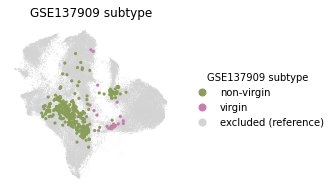

In [37]:
fig,ax=plt.subplots(figsize=(3,3))
# Background
sc.pl.umap(adata_embed[cells_plot,:],ax=ax,show=False, frameon=False)
# Cmap for coloring and legend
cmap={'non-virgin':'#8a9e59','virgin':'#c97fac','excluded (reference)':'lightgray'}
# Get query virgin-non virgin annotation (applies to healthy adult samples);
# relies on embed data for query being already subsetted to healthy adults - 
# the original anno group 2 in healthy adults are virgin cells
adata_temp=adata_embed[adata_embed.obs.ref_query=='query',:].copy()
adata_temp.obs['GSE137909 subtype']=(obs_q_feng.loc[
    adata_temp.obs_names.str.replace('-query',''),'Putative β-cell Group']==2
                               ).replace({True:'virgin',False:'non-virgin'}).values
adata_temp.obs['GSE137909 subtype']=pd.Categorical(
    adata_temp.obs['GSE137909 subtype'],cmap.keys(),True)
# Plot query
sc.pl.umap(adata_temp,color='GSE137909 subtype',ax=ax,s=40, 
           palette=cmap, show=False)

# Add background to legend
l1=ax.legend(handles=[
    Line2D([0], [0], marker='o', color=c,lw=0, label=l,
    markerfacecolor=c, markersize=7) for l,c in cmap.items()], frameon=False)
             
l1.set_title("GSE137909 subtype") 
l1.set_bbox_to_anchor((1.05,0.75))

plt.savefig(path_fig+'umap_beta_query_virgin_eopt.png',dpi=300,bbox_inches='tight')